In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std



plt.rc("axes.spines", top=False, right=False)


import wrangle
import split_scale
import evaluate
import features

Accuire Data

In [2]:
from env import host, user, password

In [3]:
#data for baseline model
df=wrangle.get_data_from_mysql()
df_engine=df

In [4]:
df_engine.head()

,transactiondate,id,bathrooms,bedrooms,lotsizesquarefeet,sqft,tax_value,region_id
0,2017-06-30,1772,2.0,4.0,6211.0,1604.0,498347.0,12447.0
1,2017-06-01,2028,3.0,3.0,9109.0,2384.0,549917.0,12447.0
2,2017-06-01,3273,2.0,3.0,7538.0,1574.0,235272.0,5534.0
3,2017-06-29,3429,2.0,2.0,111564.0,1619.0,340000.0,40227.0
4,2017-06-27,4505,3.0,2.0,10497.0,2408.0,2017254.0,12447.0


In [5]:
df_engine.drop(['transactiondate', 'id'], axis = 1).head()

,bathrooms,bedrooms,lotsizesquarefeet,sqft,tax_value,region_id
0,2.0,4.0,6211.0,1604.0,498347.0,12447.0
1,3.0,3.0,9109.0,2384.0,549917.0,12447.0
2,2.0,3.0,7538.0,1574.0,235272.0,5534.0
3,2.0,2.0,111564.0,1619.0,340000.0,40227.0
4,3.0,2.0,10497.0,2408.0,2017254.0,12447.0


In [6]:
#data for tax rate distribution
df_tax = wrangle.taxcounty()

In [7]:
df_tax.head()

,tax_value,fips,taxamount,tax_rate
0,498347.0,6037.0,6089.82,0.0122
1,549917.0,6037.0,6679.55,0.0121
2,235272.0,6037.0,3876.31,0.0165
3,340000.0,6037.0,4206.15,0.0124
4,2017254.0,6037.0,24353.42,0.0121


Clean Data

In [8]:
df_engine.head()

,transactiondate,id,bathrooms,bedrooms,lotsizesquarefeet,sqft,tax_value,region_id
0,2017-06-30,1772,2.0,4.0,6211.0,1604.0,498347.0,12447.0
1,2017-06-01,2028,3.0,3.0,9109.0,2384.0,549917.0,12447.0
2,2017-06-01,3273,2.0,3.0,7538.0,1574.0,235272.0,5534.0
3,2017-06-29,3429,2.0,2.0,111564.0,1619.0,340000.0,40227.0
4,2017-06-27,4505,3.0,2.0,10497.0,2408.0,2017254.0,12447.0


In [9]:
df_engine = df.filter(['bedrooms','bathrooms','sqft', 'lotsizesquarefeet', 'region_id','tax_value'], axis=1)

In [10]:
df_engine.head()

,bedrooms,bathrooms,sqft,lotsizesquarefeet,region_id,tax_value
0,4.0,2.0,1604.0,6211.0,12447.0,498347.0
1,3.0,3.0,2384.0,9109.0,12447.0,549917.0
2,3.0,2.0,1574.0,7538.0,5534.0,235272.0
3,2.0,2.0,1619.0,111564.0,40227.0,340000.0
4,2.0,3.0,2408.0,10497.0,12447.0,2017254.0


Split and Scale Data

In [11]:
train_engine, test_engine = split_scale.split_my_data(df_engine,train_ratio=.8,seed=123)

In [12]:
# impute a random column so we can test our feature engineering functions

scaler, train_scaled, test_scaled = \
    split_scale.standard_scaler(train_engine, test_engine)

In [13]:
X_train_engine = train_engine.drop(columns='tax_value')
y_train_engine = train_engine[['tax_value']]
X_test_engine = test_engine.drop(columns='tax_value')
y_test_engine = test_engine[['tax_value']]

Data Exploration

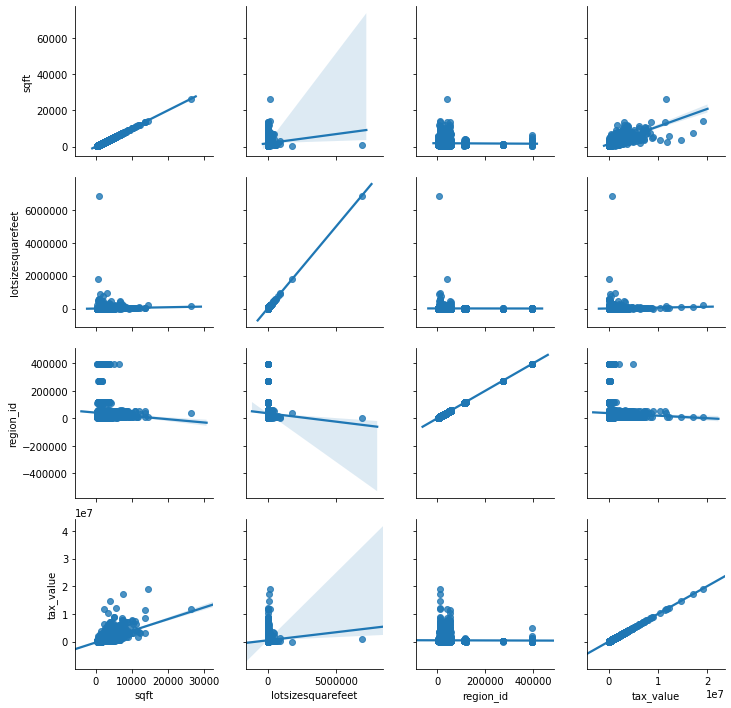

In [14]:
g=sns.PairGrid(df[['sqft', 'lotsizesquarefeet', 'region_id','tax_value']])
g.map(sns.regplot)
plt.show()

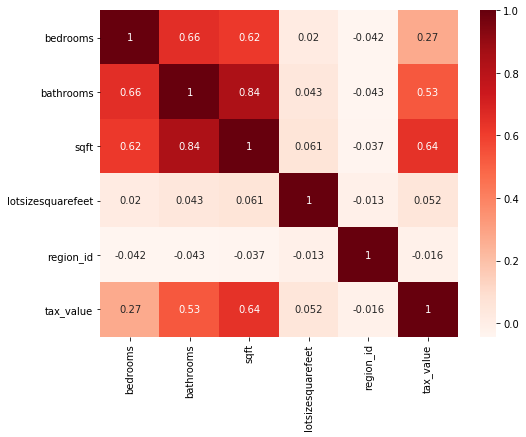

In [15]:
plt.figure(figsize=(8,6))
cor = train_engine.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Reds)
plt.show()

Feature Engieering

In [16]:
train_engine['filler'] = -1
test_engine['filler'] = -1

train_scaled['filler'] = 1
test_scaled['filler'] = 1

In [17]:
train_scaled.head()

,bedrooms,bathrooms,sqft,lotsizesquarefeet,region_id,tax_value,filler
3396,-2.368441,-1.189873,-1.147011,-0.081050,-0.417016,-0.520056,1
9893,0.790348,-0.200811,0.012995,-0.043387,-0.164886,-0.262680,1
6069,-0.262581,-0.200811,-0.200004,-0.072112,-0.431133,-0.414941,1
14615,0.790348,0.788251,0.317875,-0.081616,-0.445783,0.427009,1
3172,-1.315511,-1.189873,-0.433884,-0.056350,0.177448,-0.048798,1


In [18]:
#Ktest
features.select_kbest_freg_unscaled(X_train_engine, y_train_engine, 3)

['bedrooms', 'bathrooms', 'sqft']

In [19]:
#Ktest
features.select_kbest_freg_scaled(X_train_engine, y_train_engine, 3)

['bedrooms', 'bathrooms', 'sqft']

In [20]:
#Backward elimination
#takes scaled dataframes (X and y) as input and returns selected features based on the ols backwards elimination method.
features.ols_backward_elimination(X_train_engine, y_train_engine)

['bedrooms', 'bathrooms', 'sqft']

In [21]:
df_engine.describe()

,bedrooms,bathrooms,sqft,lotsizesquarefeet,region_id,tax_value
count,15669.000000,15669.000000,15669.000000,1.566900e+04,15669.000000,1.566900e+04
mean,3.247750,2.204895,1826.649244,1.042676e+04,36757.729657,4.605711e+05
std,0.945078,1.019685,972.427738,6.083505e+04,58273.790563,6.422877e+05
min,1.000000,1.000000,320.000000,5.840000e+02,3491.000000,7.584000e+03
25%,3.000000,2.000000,1232.000000,5.569000e+03,12447.000000,1.803100e+05
50%,3.000000,2.000000,1586.000000,6.708000e+03,24384.000000,3.169390e+05
75%,4.000000,3.000000,2142.000000,8.494000e+03,45888.000000,5.250000e+05
max,25.000000,20.000000,26345.000000,6.845666e+06,396556.000000,1.912982e+07


In [22]:
#acquiring county names based on fips field
#from: https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
df_tax['county'] = np.where(df_tax['fips']== 6037,'Los Angles',(np.where(df_tax['fips']== 6059,'Orange',(np.where(df_tax['fips']==6111,'Ventura',"")))))

In [23]:
df_tax.head()
df_tax.describe()

,tax_value,fips,taxamount,tax_rate
count,1.595600e+04,15956.000000,15956.000000,15956.000000
mean,4.634078e+05,6044.487591,5681.839846,0.013342
std,6.434229e+05,17.283469,7466.645847,0.003730
min,1.216800e+04,6037.000000,49.180000,0.000000
25%,1.820338e+05,6037.000000,2496.027500,0.011900
50%,3.205150e+05,6037.000000,4065.150000,0.012500
75%,5.286050e+05,6037.000000,6409.490000,0.013700
max,1.912982e+07,6111.000000,228999.210000,0.155100


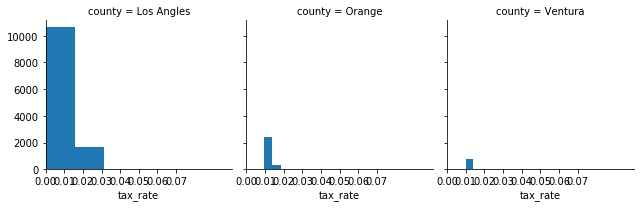

In [24]:
#Tax distribution by county.

from matplotlib import pyplot as plt

g = sns.FacetGrid(df_tax, col = "county")
g.map(plt.hist, "tax_rate")
plt.xlim(0,.1)
plt.xticks(np.arange(0, .07, step=0.01))

plt.show()

In [25]:
sns.pairplot(df_base)

NameError: name 'df_base' is not defined

Split and Scale

In [ ]:
train, test = split_scale.split_my_data(df_base,train_ratio=.8,seed=123)

In [ ]:
X_train = train.drop(columns='taxvaluedollarcnt')
y_train = train[['taxvaluedollarcnt']]
X_test = test.drop(columns='taxvaluedollarcnt')
y_test = test[['taxvaluedollarcnt']]

In [ ]:
plt.figure(figsize=(8,6))
cor = train.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Reds)
plt.show()

In [ ]:
import statsmodels.api as sm

#OLS object to analyze features

ols_model = sm.OLS(y_train, X_train)
regr = sm.OLS(y, X).fit()
regr.summary()

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
#OLS object to analyze features

# ols_model = sm.OLS(y_train,X_train)
# fit = ols_model.fit()
# fit.summary()

ols_model = ols('y_train ~ X_train',data=train).fit()
train['yhat'] = ols_model.predict(y_train)

In [ ]:
#r2 of 
r2_lm1 = r2_score(y_train,train.yhat)
r2_lm1

In [ ]:
#creating baseline with mean of tax value
train['taxvaluedollarcnt'] = train.taxvaluedollarcnt.mean()
train.head()

In [ ]:
#creating residual of tax value vs expected tax value
train['residual'] = train['yhat'] - train['taxvaluedollarcnt']
train['residual2'] = train.residual **2

In [ ]:
train.head()

MVP

In [ ]:
from sklearn.linear_model import LinearRegression
#pick model type, Linear Regression for the MVP baseline
lm = LinearRegression()

In [ ]:
#fit and train model
lm.fit(X_train,y_train)
lm_y_intercept = lm.intercept_
lm_coefficients = lm.coef_

print('{} = b + m1 * {} + m2 * {}'.format(y_train.columns[0], X_train.columns[0],X_train.columns[1]))
print('    y-intercept  (b): %.2f' % lm_y_intercept)
print('    coefficient (m1): %.2f' % lm_coefficients[0][0])
print('    coefficient (m2): %.2f' % lm_coefficients[0][1])

In [ ]:
#converting y_train Series
y_train = y_train.taxvaluedollarcnt

In [ ]:
#Residuals
sns.residplot(y_train,train.yhat)

In [ ]:
#MSE, SSE, RMSE
import math
sse = sum(train.residual2)
mse = sse/len(train)
rmse = math.sqrt(mse)
r2 = ols_model.rsquared
print(sse,mse,rmse,r2)

In [ ]:
print("R= ", r2)

In [ ]:
pd.DataFrame({'actual': y_train,
              'lm': train.yhat,
              'lm_baseline': train.taxvaluedollarcnt})\
.melt(id_vars=['actual'], var_name='model', value_name='prediction')\
.pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')


min, max = 0, 5_000_000
plt.plot([min, max], [min, max], c='black', ls=':')
plt.ylim(min, max)
plt.xlim(min, max)
plt.title('Predicted vs Actual Tax Value')

In [ ]:
mse_lm = mean_squared_error(y_train,train.taxvaluedollarcnt)
print("linear model\n  mean squared error: {:.3}".format(mse_lm)) 

In [ ]:
MVP= r2

In [ ]:
MVP